# Initialisation

In [1]:
root_dir = "/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/"

## General imports

In [2]:
import io
import csv
import os.path

import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt

%matplotlib qt5

In [3]:
import sys

In [4]:
sys.path.insert(0, "/home/pleroy/DEV/processing/PoSAR-MC")
from posarmctools.ekfnavtools import *

In [5]:
sys.path.insert(0, "/home/pleroy/DEV/processing/focalization_python")
from posarutils.other.PosarMCParameters import *

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
withPlots = 0

## EPSG transformations

In [8]:
import mpl_toolkits.basemap.pyproj as pyproj

In [9]:
# Define some common projections using EPSG codes
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
epsg3857 = pyproj.Proj("+init=EPSG:3857") # WGS84 / Pseudo Mercator
epsg3395 = pyproj.Proj("+init=EPSG:3395") # WGS84 / World Mercator
epsg3948 = pyproj.Proj("+init=EPSG:3948") # RGF93 / CC48 Projected coordinate system

epsg3xxx = epsg3948 # epsg3857 does not seem to keep distances

In [10]:
def transform( Long_Lat, shift=0, orig=(0,0) ):
    
    if shift:
        epsg = pyproj.transform(wgs84, epsg3xxx, Long_Lat[0], Long_Lat[1])
        epsg = (epsg[0] - orig[0], epsg[1] - orig[1])
    else:
        epsg = pyproj.transform(wgs84, epsg3xxx, Long_Lat[0], Long_Lat[1])
        
    return epsg

In [11]:
if epsg3xxx == epsg3857:
    origXY = (-180000, 6183000) # epsg 3857
    shiftXY = 1
    xlim = 17500
    ylim = 17500
    epsgStr = "epsg3857"
    
if epsg3xxx == epsg3948:
    origXY = (1360000, 7260000)
    shiftXY = 1
    #xlim = 11000
    #ylim = 12000
    xmin = 1358000
    xmax = 1371000
    ymin = 7260000
    ymax = 7272500
    epsgStr = "epsg3948"

## Scene remarkable points

In [12]:
def getLatLong( a, b ):
    Da = float(a.split("°")[0])
    r = a.split("°")[1]
    Ma = float(r.split("'")[0])
    r = r.split("'")[1]
    Sa = float(r.split("N")[0])
    
    Db = float(b.split("°")[0])
    r = b.split("°")[1]
    Mb = float(r.split("'")[0])
    r = r.split("'")[1]
    Sb = float(r.split("W")[0])
    
    return ( Da + Ma/60 + Sa/3600, -(Db + Mb/60 + Sb/3600) )

In [13]:
J1 = [ 48 + 28/60 + 8.08/3600, -(1 + 29/60 + 26.72/3600) ]
J2 = [ 48 + 32/60 + 31.59/3600, -(1 + 35/60 + 15.44/3600) ]
J3 = [ 48 + 32/60 + 36.80/3600, -(1 + 35/60 + 4.86/3600) ]   
J4 = [ 48 + 28/60 + 15.03/3600, -(1 + 29/60 + 16.23/3600) ]
J5 = getLatLong( "48°28'21.95N", "1°29'5.65W" )
J6 = getLatLong( "48°32'42.05N", "1°34'54.30W" )
J7 = getLatLong( "48°32'47.28N", "1°34'43.73W" )
J8 = getLatLong( "48°28'28.87N", "1°28'55.04W" )
J9 = getLatLong( "48°28'35.79N", "1°28'44.44W" )
J10 = getLatLong( "48°32'52.51N", "1°34'33.18W" )
J11 = [ 48 + 32 / 60 + 57.92 / 3600, -(1 + 34 / 60 + 22.25 / 3600) ]
J12 = [ 48 + 28 / 60 + 42.91 / 3600, -(1 + 28 / 60 + 33.18 / 3600) ]

J1_epsg = transform( J1[::-1] )
J2_epsg = transform( J2[::-1] )
J3_epsg = transform( J3[::-1] )
J4_epsg = transform( J4[::-1] )
J5_epsg = transform( J5[::-1] )
J6_epsg = transform( J6[::-1] )
J7_epsg = transform( J7[::-1] )
J8_epsg = transform( J8[::-1] )
J9_epsg = transform( J9[::-1] )
J10_epsg = transform( J10[::-1] )
J11_epsg = transform( J11[::-1] )
J12_epsg = transform( J12[::-1] )

np.save( root_dir + "J1_epsg", J1_epsg )
np.save( root_dir + "J2_epsg", J2_epsg )
np.save( root_dir + "J3_epsg", J3_epsg )
np.save( root_dir + "J4_epsg", J4_epsg )
np.save( root_dir + "J5_epsg", J5_epsg )
np.save( root_dir + "J6_epsg", J6_epsg )
np.save( root_dir + "J7_epsg", J7_epsg )
np.save( root_dir + "J8_epsg", J8_epsg )
np.save( root_dir + "J9_epsg", J9_epsg )
np.save( root_dir + "J10_epsg", J10_epsg )
np.save( root_dir + "J11_epsg", J11_epsg )
np.save( root_dir + "J12_epsg", J12_epsg )

# SBG data

## data path definitions

In [14]:
day = "2018_06_27"
prefix = "/home/pleroy/DATA/2018_06_27_LETG/dataLogger/session_0005/" + day + "/"

hours = ["09h00", "10h00", "11h00", "12h00"]
nbHours = len(hours)

logEkfEuler = [ prefix + h + "/sbgLogEkfEuler.dat" for h in hours ]
logEkfNav  = [ prefix + h + "/sbgLogEkfNav.dat" for h in hours ]
logUtcData = [ prefix + h + "/sbgLogUtcData.dat" for h in hours ]
logGpsPos = [ prefix + h + "/sbgLogGpsPos.csv" for h in hours ]
logGpsVel = [ prefix + h + "/sbgLogGpsVel.dat" for h in hours ]
logEventB = [ prefix + h + "/sbgLogEventB.dat" for h in hours ]

##  logGpsPos

In [15]:
idx_gpsPos_lat = 3
idx_gpsPos_long = 4
idx_gpsPos_alt = 5
idx_gpsPos_undulation = 6
idx_gps_lat = 1
idx_gps_long = 2
idx_gps_alt = 3
idx_gps_undulation = 4

def loadLogGpsPos( gps, n ):
    for idx in range(n):
        gps.append( np.loadtxt( logGpsPos[idx], skiprows = 1, delimiter = ',',
                               usecols = (0, idx_gpsPos_lat, idx_gpsPos_long, idx_gpsPos_alt, idx_gpsPos_undulation) ) )

### Load data

In [16]:
gps=[]
loadLogGpsPos( gps, nbHours )

In [17]:
gps_all = gps[0]
for idx in range(1, 4):
    gps_all = np.concatenate( (gps_all, gps[idx]), axis=0 )

In [18]:
Lat = gps_all[:,idx_gps_lat]
Long = gps_all[:,idx_gps_long]
Alt = gps_all[:,idx_gps_alt]
Undulation = gps_all[:,idx_gps_undulation]

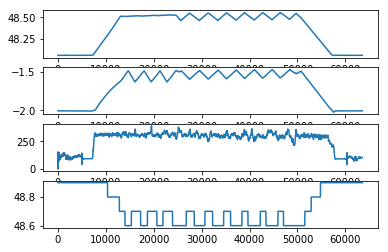

In [19]:
plt.figure()
plt.subplot(411)
plt.plot(Lat)
plt.subplot(412)
plt.plot(Long)
plt.subplot(413)
plt.plot(Alt)
plt.subplot(414)
plt.plot(Undulation)

### Plot navigation data jointly with track references

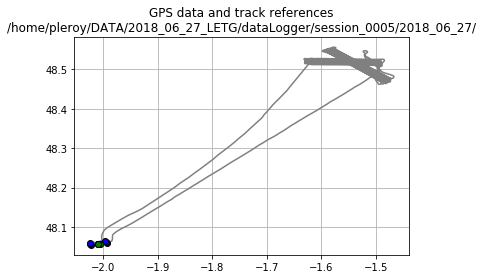

In [20]:
plt.figure()
ax = plt.subplot(111)
plotLongLatAndTrackReferences( ax, Long, Lat )
plotRunaway( ax )
plt.title( "GPS data and track references\n" + prefix )
plt.grid()

### Shift timestamps

In [21]:
gpsTimestamps = gps_all[:, 0]

In [22]:
for k in range(1,gpsTimestamps.shape[0]):
    if gpsTimestamps[k] < gpsTimestamps[k-1]:
        print("k = {}".format(k))

k = 3734
k = 25209
k = 46684


In [23]:
k1 = 3734
k2 = 25209
k3 = 46684
gpsNewTimestamps = np.concatenate( (gpsTimestamps[:k1],
                                    gpsTimestamps[k1:k2] + 1*2**32, 
                                    gpsTimestamps[k2:k3] + 2*2**32, 
                                    gpsTimestamps[k3:] + 3*2**32) )

In [24]:
if withPlots:
    plt.figure()
    plt.plot( gpsNewTimestamps, 'o' )
    plt.plot( gpsTimestamps,'.' )
    plt.grid()

### Transform GPS data

In [25]:
idx_lat = 1
idx_long = 2

In [26]:
idx = 0
x0, y0 = transform( (gps[idx][:,idx_long], gps[idx][:,idx_lat]) )

idx = 1
x1, y1 = transform( (gps[idx][:,idx_long], gps[idx][:,idx_lat]) )

idx = 2
x2, y2 = transform( (gps[idx][:,idx_long], gps[idx][:,idx_lat]) )

idx = 3
x3, y3 = transform( (gps[idx][:,idx_long], gps[idx][:,idx_lat]) )

x = [x0, x1, x2, x3]
y = [y0, y1, y2, y3]

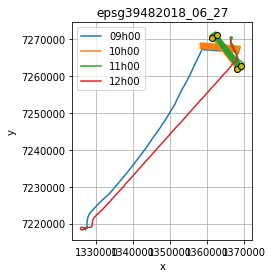

In [27]:
plt.figure()
for idx in range(4):
    plt.plot( x[idx], y[idx], label=hours[idx] )
    
plt.plot( J1_epsg[0], J1_epsg[1], 'oy', markeredgecolor = 'black' )
plt.plot( J2_epsg[0], J2_epsg[1], 'oy', markeredgecolor = 'black' )
plt.plot( J11_epsg[0], J11_epsg[1], 'oy', markeredgecolor = 'black' )
plt.plot( J12_epsg[0], J12_epsg[1], 'oy', markeredgecolor = 'black' )

plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
title = epsgStr + day
plt.title(title)
plt.gca().set_aspect('equal')

In [28]:
gps_proj = transform( (Long, Lat) )
np.save( root_dir + "gps_epsg_transform", gps_proj )

## logGpsVel

### Load data

In [29]:
idx_gpsVel_north = 3
idx_gpsVel_east = 4
idx_gpsVel_down = 5
idx_gpsVel_course = 9

vel=[]
for idx in range(4):
    vel.append( np.loadtxt( logGpsVel[idx], skiprows = 1,
                           usecols = (0, idx_gpsVel_north, idx_gpsVel_east, idx_gpsVel_down, idx_gpsVel_course) ) )

In [30]:
vel_all = vel[0]
for idx in range(1, 4):
    vel_all = np.concatenate( (vel_all, vel[idx]), axis=0 )

In [31]:
Vel = ( vel_all[:,1]**2 + vel_all[:,2]**2 + vel_all[:,3]**2) **0.5
course = vel_all[:,4]

## sbgLogEventB

### Load data

In [32]:
event = []
for idx in range(4):
    event.append( np.loadtxt( logEventB[idx], skiprows = 1, usecols = 0 ) )

indexes = []
indexes.append( np.arange(event[0].size) )
for idx in range(1, 4):
    indexes.append( np.arange(event[idx].size)+indexes[idx-1][-1]+1)

In [33]:
event_all = event[0]
for idx in range(1, 4):
    event_all = np.concatenate( (event_all, event[idx]), axis=0 )

Text(0.5,1,'sbgLogEventB / 1e6\n/home/pleroy/DATA/2018_06_27_LETG/dataLogger/session_0005/2018_06_27/')

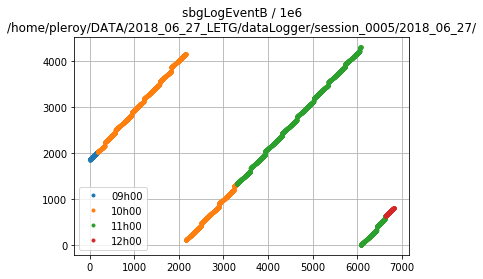

In [34]:
plt.figure()
for idx in range(4):
    plt.plot( indexes[idx], event[idx]/1e6, ".", label = "{}".format(hours[idx]) )
    
plt.legend()
plt.grid()
title = "sbgLogEventB / 1e6\n" + prefix
plt.title(title)

Text(0.5,1,'diff sbgLogEventB / 1e6\n/home/pleroy/DATA/2018_06_27_LETG/dataLogger/session_0005/2018_06_27/')

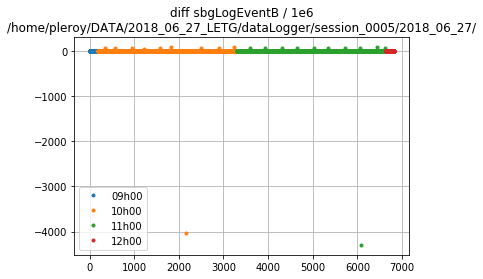

In [35]:
plt.figure()
for idx in range(4):
    plt.plot( indexes[idx][:-1], np.diff(event[idx])/1e6, ".", label = "{}".format(hours[idx]) )
    
plt.legend()
plt.grid()
title = "diff sbgLogEventB / 1e6\n" + prefix
plt.title(title)

## logUtcData

### Load data

In [36]:
#timeStamp status year month day hour minute second nanoSecond gpsTimeOfWeek
idx_h = 5
idx_m = 6
idx_s = 7
idx_nano = 8

utc = []
for idx in range(4):
    utc.append( np.loadtxt( logUtcData[idx], skiprows = 1, usecols = (0, idx_h, idx_m, idx_s, idx_nano) ) )

In [37]:
utc_all = utc[0]
for idx in range(1, 4):
    utc_all = np.concatenate( (utc_all, utc[idx]), axis=0 )

In [38]:
printUtc( 0, utc_all )
printUtc( -1, utc_all )

9.0 : 13.0 : 50.750
12.0 : 45.0 : 37.775


In [39]:
utcTimestamps = utc_all[:, 0]

### Shift timestamps

In [40]:
for k in range(1,utcTimestamps.shape[0]):
    if utcTimestamps[k] < utcTimestamps[k-1]:
        print("k = {}".format(k))

k = 149353
k = 1008346
k = 1867340


In [41]:
k1 = 149353
k2 = 1008346
k3 = 1867340
utcNewTimestamps = np.concatenate( (utcTimestamps[:k1], 
                                    utcTimestamps[k1:k2] + 1*2**32,
                                    utcTimestamps[k2:k3] + 2*2**32, 
                                    utcTimestamps[k3:] + 3*2**32) )

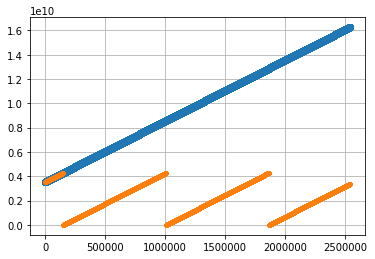

In [42]:
if 1:
    plt.figure()
    plt.plot( utcNewTimestamps, 'o' )
    plt.plot( utcTimestamps,'.' )
    plt.grid()

In [43]:
printUtc( 0, utc_all )
printUtc( k1, utc_all )
printUtc( k2, utc_all )
printUtc( k3, utc_all )
printUtc( -1, utc_all )

9.0 : 13.0 : 50.750
9.0 : 26.0 : 17.515
10.0 : 37.0 : 52.480
11.0 : 49.0 : 27.450
12.0 : 45.0 : 37.775


## logEkfEuler

### Load data

In [44]:
idx_timeStamp = 0
idx_roll = 1
idx_pitch = 2
idx_yaw = 3
idx_rollStdDev = 4
idx_pitchStdDev = 5
idx_yawStdDev = 6
idx_status = 7

In [45]:
euler = []
for idx in range(4):
    euler.append( np.loadtxt( logEkfEuler[idx], skiprows = 1,
                             usecols = (0, idx_roll, idx_pitch, idx_yaw) ) )

In [46]:
euler_all = euler[0]
for idx in range(1, 4):
    euler_all = np.concatenate( (euler_all, euler[idx]), axis=0 )

In [47]:
eulerTimestamps = euler_all[:,0]
roll = euler_all[:,1]
pitch = euler_all[:,2]
yaw = euler_all[:,3]

### Shift timestamps

In [48]:
for k in range(1,eulerTimestamps.shape[0]):
    if eulerTimestamps[k] < eulerTimestamps[k-1]:
        print("k = {}".format(k))

k = 149353
k = 1008346
k = 1867340


In [49]:
k1 = 149353
k2 = 1008346
k3 = 1867340
eulerNewTimestamps = np.concatenate( (eulerTimestamps[:k1], 
                                      eulerTimestamps[k1:k2] + 1*2**32,
                                      eulerTimestamps[k2:k3] + 2*2**32, 
                                      eulerTimestamps[k3:] + 3*2**32) )

## logEkfNav

### Load data

In [50]:
idx_timeStamp = 0
idx_velNorth = 1
idx_velEast = 2
idx_velDown = 3
idx_velNorth_StdDev = 4
idx_velEast_StdDev = 5
idx_velDown_StdDev = 6
idx_ekf_Lat = 7
idx_ekf_Long = 8
idx_ekf_Alt = 9
idx_ekf_undulation = 10
dx_ekf_Lat_StdDev = 11
idx_ekf_Long_StdDev = 12
idx_ekf_Alt_StdDev = 13
idx_status = 14

In [51]:
nav = []
for idx in range(4):
    nav.append( np.loadtxt( logEkfNav[idx], skiprows = 1,
                             usecols = (0, idx_ekf_Lat, idx_ekf_Long, idx_ekf_Alt, idx_ekf_undulation) ) )

In [52]:
nav_all = nav[0]
for idx in range(1, 4):
    nav_all = np.concatenate( (nav_all, nav[idx]), axis=0 )

In [53]:
navTimestamps = nav_all[:,0]
nav_Lat = nav_all[:,1]
nav_Long = nav_all[:,2]
nav_Alt = nav_all[:,3]
nav_Undulation = nav_all[:,4]

### Shift timestamps

In [54]:
for k in range(1,navTimestamps.shape[0]):
    if navTimestamps[k] < navTimestamps[k-1]:
        print("k = {}".format(k))

k = 149353
k = 1008346
k = 1867340


In [55]:
k1 = 149353
k2 = 1008346
k3 = 1867340
navNewTimestamps = np.concatenate( (navTimestamps[:k1], 
                                    navTimestamps[k1:k2] + 1*2**32,
                                    navTimestamps[k2:k3] + 2*2**32, 
                                    navTimestamps[k3:] + 3*2**32) )

In [56]:
nav_proj = transform( (nav_Long, nav_Lat) )
np.save( root_dir + "nav_epsg_transform", nav_proj )

In [57]:
origXY

(1360000, 7260000)

Text(0.5,1,'comparison between nav and gps data')

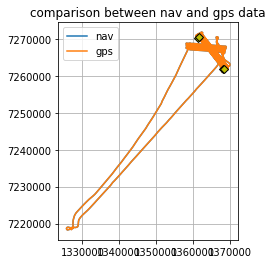

In [58]:
plt.figure()
plt.plot( nav_proj[0], nav_proj[1], label = "nav" )
plt.plot( gps_proj[0], gps_proj[1], label = "gps" )
plt.plot(J1_epsg[0], J1_epsg[1], "Dy", markerEdgecolor="k")
plt.plot(J2_epsg[0], J2_epsg[1], "Dy", markerEdgecolor="k")
plt.plot(J3_epsg[0], J3_epsg[1], "Dy", markerEdgecolor="k")
plt.plot(J4_epsg[0], J4_epsg[1], "Dy", markerEdgecolor="k")
plt.legend()
plt.grid()
plt.gca().set_aspect('equal')
title = "comparison between nav and gps data"
plt.title(title)

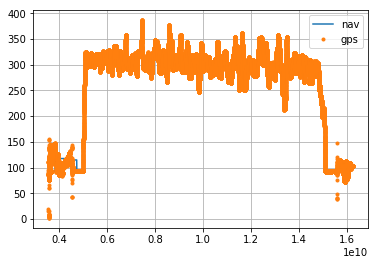

In [59]:
plt.figure()
plt.plot(navNewTimestamps, nav_Alt, label = "nav")
plt.plot(gpsNewTimestamps, Alt, '.', label = "gps")
plt.legend()
plt.grid()

# PoSAR-MC data

## Parameters

In [60]:
dates = ["12_39_39", "12_45_51", "12_52_49", "12_59_03",
         "13_05_40", "13_11_42", "13_18_13", "13_24_11",
         "13_30_53", "13_36_46", "13_43_13", "13_49_07"]

data_date = [ "2018_06_27_" + d for d in dates ]
data_dir = [root_dir +  d for d in data_date]

firstRecord = 0
lastRecord = [682, 780, 656, 736,
              640, 750, 648, 744,
              656, 742, 646, 756
             ]

## Process timeStamps.data

In [61]:
def checkTimestamps(idx, dropFirst=0, withPlot=1):
    
    #====================================================================
    # the last value of the file may be erroneous, this should be checked
    #====================================================================

    #===================================================================
    # the first value may be erroneous, one may have to shift all values
    #===================================================================
    
    timeStampsFile = data_dir[idx] + "/" + data_date[idx] + "_timeStamps.data"
    print(timeStampsFile)
    bufferNumber, timeStamp = np.loadtxt( timeStampsFile, skiprows = 1, unpack=True )

    if dropFirst:
        bufferNumber = bufferNumber[:-1]
        timeStamp = timeStamp[1:]
    
    if withPlot:
        plt.figure()
        plt.subplot(211)
        plt.plot( timeStamp, ".", label=data_date[idx] )
        plt.grid()
        plt.legend()
        plt.title("timeStamp wrt fileNumber / " + data_date[idx] )
        plt.subplot(212)
        plt.plot( np.diff(timeStamp)/1e6, "." )
        plt.grid()
        plt.title( "diff(timeStamp) wrt fileNumber / " + data_date[idx] )
    
    return bufferNumber, timeStamp

In [62]:
bufferNumber = {}
timeStamp = {}

In [63]:
rec = 0
dropFirst=1
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_12_39_39/2018_06_27_12_39_39_timeStamps.data


In [64]:
rec = 1
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_12_45_51/2018_06_27_12_45_51_timeStamps.data


In [65]:
rec = 2
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_12_52_49/2018_06_27_12_52_49_timeStamps.data


In [66]:
rec = 3
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_12_59_03/2018_06_27_12_59_03_timeStamps.data


In [67]:
rec = 4
dropFirst=1
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_13_05_40/2018_06_27_13_05_40_timeStamps.data


In [68]:
rec = 5
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_13_11_42/2018_06_27_13_11_42_timeStamps.data


In [69]:
rec = 6
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_13_18_13/2018_06_27_13_18_13_timeStamps.data


In [70]:
rec = 7
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_13_24_11/2018_06_27_13_24_11_timeStamps.data


In [71]:
rec = 8
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_13_30_53/2018_06_27_13_30_53_timeStamps.data


In [72]:
rec = 9
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_13_36_46/2018_06_27_13_36_46_timeStamps.data


In [73]:
rec = 10
dropFirst=1
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_13_43_13/2018_06_27_13_43_13_timeStamps.data


In [74]:
# this record is special, the SBG internal loopback occurs during the record
rec = 11
dropFirst=0
withPlot=0
bufferNumber[rec], timeStamp[rec] = checkTimestamps(rec, dropFirst, withPlot)

/home/pleroy/DATA/2018_06_27_LETG/2018_06_27/jde/2018_06_27_13_49_07/2018_06_27_13_49_07_timeStamps.data


**Be carefull here, there could be a jump in the timeStamp values due to the counter saturation at 2^32. The mitigation is following.**

In [75]:
timestampsShift = {}
timestampsShift[0] = 2 # this is for the SBG internal us loopback
timestampsShift[1] = 2
timestampsShift[2] = 2
timestampsShift[3] = 2
timestampsShift[4] = 2
timestampsShift[5] = 2
timestampsShift[6] = 2
timestampsShift[7] = 2
timestampsShift[8] = 2
timestampsShift[9] = 2
timestampsShift[10] = 2
timestampsShift[11] = 2

In [76]:
newTimeStamp = {}
for rec in timeStamp:
    newTimeStamp[rec] = timeStamp[rec] + timestampsShift[rec] * 2**32
    
# special shift applied on the timestamps of record 11
idx = np.where(np.diff(timeStamp[11])<0)[0][0]
newTimeStamp[11][idx+1:] = newTimeStamp[11][idx+1:] + 2**32

In [77]:
for rec in newTimeStamp:
    printUtc( np.where(utcNewTimestamps < newTimeStamp[rec][0])[0][-1], utc_all )

10.0 : 39.0 : 38.365
10.0 : 45.0 : 50.465
10.0 : 52.0 : 48.425
10.0 : 59.0 : 2.120
11.0 : 5.0 : 38.865
11.0 : 11.0 : 41.290
11.0 : 18.0 : 11.975
11.0 : 24.0 : 10.265
11.0 : 30.0 : 53.895
11.0 : 36.0 : 44.605
11.0 : 43.0 : 11.660
11.0 : 49.0 : 6.180


## Selected record

In [78]:
selectedRecord = 11

In [79]:
idxTmp = np.where(event[2] == timeStamp[selectedRecord][0])

Text(0.5,1,'sbgLogEventB / 1e6, internal logs vs PoSAR logs\n2018_06_27_13_49_07')

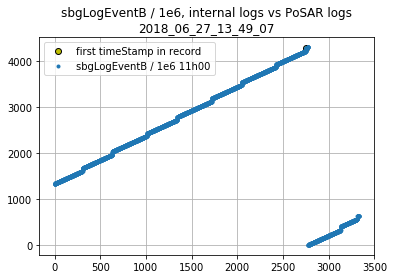

In [80]:
plt.figure()
plt.plot( idxTmp, event[2][idxTmp]/1e6, "o", markeredgecolor="k", color="y", label = "first timeStamp in record" )
plt.plot( event[2]/1e6, ".", label = "sbgLogEventB / 1e6 {}".format(hours[2]) )
plt.legend()
plt.grid()
title = "sbgLogEventB / 1e6, internal logs vs PoSAR logs\n" + data_date[selectedRecord]
plt.title(title)

### Read parameters

In [81]:
params_filename = data_dir[selectedRecord] + "/" + data_date[selectedRecord] + "_parameters.xml"
params = PosarMCParameters_v2( params_filename )

In [82]:
def getNbRecords( first, last, params ):
    nbRecords = [int((l - first) / params.buffersPerFile + 1) for l in last]
    return nbRecords

In [83]:
samplesPerRamp = params.samplesPerRamp
rampsPerFile = params.rampsPerFile
rampsPerBuffer = params.rampsPerBuffer
samplesPerFile = params.samplesPerRamp * params.rampsPerFile
buffersPerFile = params.buffersPerFile
T_files = samplesPerFile / 10e6

nbRecords = getNbRecords(firstRecord, lastRecord, params)

print( "nbRecords = {}".format(nbRecords) )
print( "selectedRecord => {} files".format(nbRecords[selectedRecord]) )

nbRecords = [342, 391, 329, 369, 321, 376, 325, 373, 329, 372, 324, 379]
selectedRecord => 379 files


### Check the existence of the files

In [84]:
fileList = []

for k in range(firstRecord, lastRecord[selectedRecord], buffersPerFile):
    filename = data_dir[selectedRecord] + "/record" + str(k) + ".bin"
    ret = os.path.isfile(filename)
    if ret == False:
        fileList.append(0)
    else:
        fileList.append(1)

idxFileList = np.arange( len( fileList ) ) * buffersPerFile + firstRecord

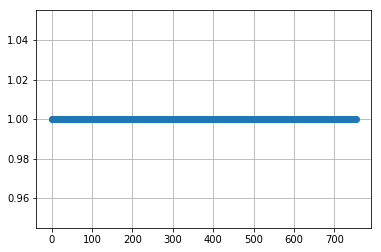

In [85]:
plt.figure()
plt.plot(idxFileList, fileList, 'o-')
plt.grid()

## Data interpolation

In [86]:
selectedTimeStamp = newTimeStamp[selectedRecord]
selectedBufferNumber = bufferNumber[selectedRecord]

### logEkfEuler

In [87]:
# interpolate euler data for all timeStamps
roll_selection = np.interp( selectedTimeStamp, eulerNewTimestamps, roll )
pitch_selection = np.interp( selectedTimeStamp, eulerNewTimestamps, pitch )
yaw_selection = np.interp( selectedTimeStamp, eulerNewTimestamps, yaw )

In [88]:
if withPlots:
    plt.figure()
    ax = plt.subplot(211)
    plt.plot(eulerNewTimestamps, yaw, label="yaw")
    plt.legend()
    plt.grid()
    plt.subplot(212, sharex=ax)
    plt.plot(gpsNewTimestamps, Alt, label="alt")
    plt.legend()
    plt.grid()

### logGpsPos

In [89]:
velNewTimestamps = gpsNewTimestamps

def getInterpolatedGps( timeStamp ):
    
    Lat_records = np.interp( timeStamp, gpsNewTimestamps, Lat )
    Long_records = np.interp( timeStamp, gpsNewTimestamps, Long )
    Alt_records = np.interp( timeStamp, gpsNewTimestamps, Alt )
    Vel_records = np.interp( timeStamp, velNewTimestamps, Vel )
    course_records = np.interp( timeStamp, velNewTimestamps, course )
    
    return Lat_records, Long_records, Alt_records, Vel_records, course_records

In [90]:
Lat_Long_Alt_Vel_course = getInterpolatedGps( selectedTimeStamp )
epsg = transform( (Lat_Long_Alt_Vel_course[1], Lat_Long_Alt_Vel_course[0]) )

In [91]:
def addRemarkablePoints():
    plt.plot( J1_epsg[0], J1_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J2_epsg[0], J2_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J3_epsg[0], J3_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J4_epsg[0], J4_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J5_epsg[0], J5_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J6_epsg[0], J6_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J7_epsg[0], J7_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J8_epsg[0], J8_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J9_epsg[0], J9_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J10_epsg[0], J10_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J11_epsg[0], J11_epsg[1], 'oy', markeredgecolor = 'black' )
    plt.plot( J12_epsg[0], J12_epsg[1], 'oy', markeredgecolor = 'black' )

## Plot navigation data and record periods

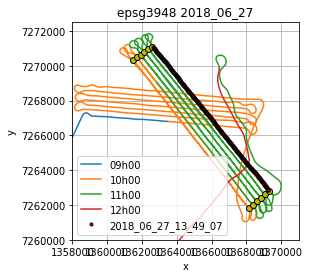

In [92]:
plt.figure()
for idx in range(4):
    plt.plot( x[idx], y[idx], label=hours[idx] )
    
addRemarkablePoints()
    
plt.plot( epsg[0], epsg[1], ".r", markeredgecolor='black', label=data_date[selectedRecord] )

plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
title = epsgStr + " " + day
plt.title(title)
plt.gca().set_aspect('equal')
ax = plt.gca()
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.savefig( data_dir[selectedRecord] + "/" + title + ".png", bbox_inches='tight')

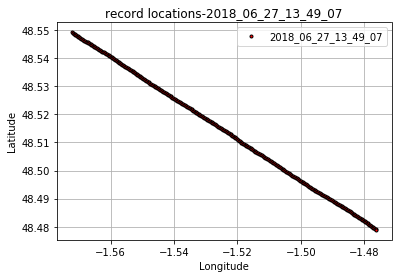

In [93]:
plt.figure()

ax = plt.subplot(111)

plt.plot( Lat_Long_Alt_Vel_course[1], Lat_Long_Alt_Vel_course[0], ".r", markeredgecolor='black', 
         label=data_date[selectedRecord] )

title = "record locations-" + data_date[selectedRecord]
plt.title(title)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid()

plt.savefig( data_dir[selectedRecord] + "/" + title + ".png", bbox_inches='tight')

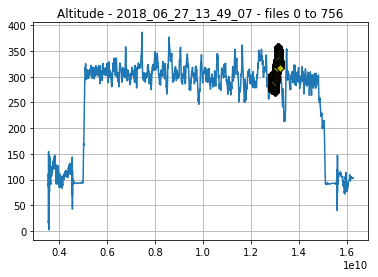

In [94]:
plt.figure()
plt.plot( gpsNewTimestamps, Alt )
plt.plot( selectedTimeStamp, Lat_Long_Alt_Vel_course[2], "yD", markeredgecolor = 'black' )
plt.grid()
title = "Altitude - " + data_date[selectedRecord] + " - files {} to {}".format(firstRecord, lastRecord[selectedRecord])
plt.title( title )
plt.savefig( data_dir[selectedRecord] + "/" + title + ".png", bbox_inches='tight')

# Track approximation

In [95]:
files = "files {} to {}".format( firstRecord, nbRecords[selectedRecord] )

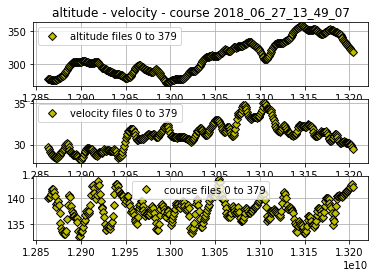

In [96]:
plt.figure()

title = "altitude - velocity - course " + data_date[selectedRecord]

plt.subplot(311)
plt.title( title )
plt.plot( selectedTimeStamp, Lat_Long_Alt_Vel_course[2], 'Dy', markeredgecolor = 'k', label="altitude " + files )
plt.legend()
plt.grid()

plt.subplot(312)
plt.plot( selectedTimeStamp, Lat_Long_Alt_Vel_course[3], 'Dy', markeredgecolor = 'k', label="velocity " + files )
plt.legend()
plt.grid()

plt.subplot(313)
plt.plot( selectedTimeStamp, Lat_Long_Alt_Vel_course[4], 'Dy', markeredgecolor = 'k', label="course " + files )
plt.legend()
plt.grid()

plt.savefig( data_dir[selectedRecord] + "/" + title + ".png", bbox_inches='tight')

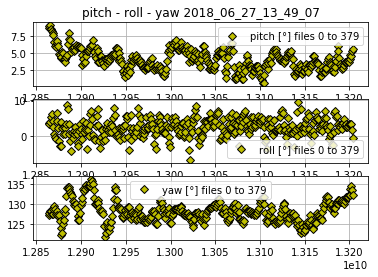

In [97]:
plt.figure()

title = "pitch - roll - yaw " + data_date[selectedRecord]

plt.subplot(311)
plt.title( title )
plt.plot( selectedTimeStamp, pitch_selection * 180 / np.pi, 'Dy', markeredgecolor = 'k', label="pitch [°] " + files )
plt.legend()
plt.grid()

plt.subplot(312)
plt.plot( selectedTimeStamp, roll_selection * 180 / np.pi, 'Dy', markeredgecolor = 'k',  label="roll [°] " + files )
plt.legend()
plt.grid()

plt.subplot(313)
plt.plot( selectedTimeStamp, yaw_selection * 180 / np.pi, 'Dy', markeredgecolor = 'k',  label="yaw [°] " + files )
plt.legend()
plt.grid()

plt.savefig( data_dir[selectedRecord] + "/" + title + ".png", bbox_inches='tight')

## Orientation vector

In [98]:
# East-West J1  => J2   12_39_39
# East-West J4  => J3   12_52_49
# East-West J5  => J6   13_05_40
# East-West J8  => J7   13_18_13
# East-West J9  => J10  13_30_53
# East-West J12 => J11  13_43_13
# West-East J2  => J1   12_45_51
# West-East J3  => J4   12_52_09
# West-East J6  => J5   13_11_42
# West-East J7  => J8   13_24_11
# West-East J10 => J9   13_36_46
# West-East J11 => J12  13_49_07
xA, yA = J11_epsg
xB, yB = J12_epsg
JA = J11
JB = J12

In [99]:
xAB = (xB - xA) / ( (xB - xA)**2 + (yB - yA)**2 )**0.5
yAB = (yB - yA) / ( (xB - xA)**2 + (yB - yA)**2 )**0.5

In [100]:
# unit vectors
ux = ( xAB, yAB )
uy = ( -yAB, xAB )

In [101]:
# build sceneReferencePoint
JA_epsg = transform( (JA[1], JA[0]) )
JB_epsg = transform( (JB[1], JB[0]) )
JAJB = ( (JA_epsg[0]+JB_epsg[0])/2,
        (JA_epsg[1]+JB_epsg[1])/2 )
shiftInY = 0
sceneReferencePoint = JAJB[0] + shiftInY * uy[0], JAJB[1] + shiftInY * uy[1]

In [102]:
import json

In [103]:
track_model = { "trackModel" : "model(x, p) = p[1]*x + p[2]",
               "ux" : (ux[0], ux[1]),
               "uy" : (uy[0], uy[1]),
               "origX" : sceneReferencePoint[0],
               "origY" : sceneReferencePoint[1]
              }

In [104]:
track_model

{'trackModel': 'model(x, p) = p[1]*x + p[2]',
 'ux': (0.6282731214519695, -0.7779928565616774),
 'uy': (0.7779928565616774, 0.6282731214519695),
 'origX': 1365944.6813786994,
 'origY': 7266956.504989682}

In [105]:
trackFilename = data_dir[selectedRecord] + "/track_model.json"
with open( trackFilename, 'w' ) as f:
    json.dump( track_model, f )

In [106]:
x_selection = np.interp( selectedTimeStamp, gpsNewTimestamps, gps_proj[0] )
y_selection = np.interp( selectedTimeStamp, gpsNewTimestamps, gps_proj[1] )
np.save( data_dir[selectedRecord] + "/track_selection_proj", np.stack( (x_selection, y_selection ), -1 ) )

(7260000, 7272500)

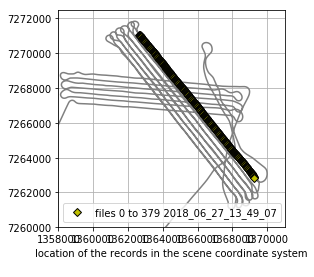

In [107]:
plt.figure()

plt.plot( gps_proj[0], gps_proj[1], "gray" )

plt.plot( x_selection, y_selection, 'Dy', markerEdgecolor='k',
        label = "files {} to {} ".format( firstRecord, nbRecords[selectedRecord] ) + data_date[selectedRecord] )

ax = plt.gca()
ax.set_aspect("equal")
plt.xlabel("location of the records in the scene coordinate system\n")
plt.grid()
plt.legend()
ax = plt.gca()
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

(7260000, 7272500)

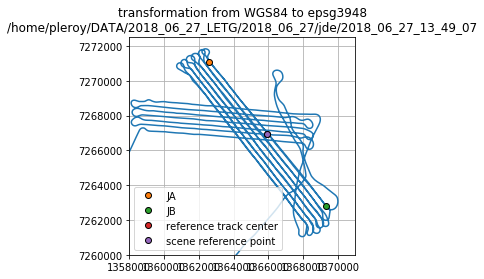

In [108]:
tmpJA = transform( (JA[1], JA[0]) )
tmpJB = transform( (JB[1], JB[0]) )
                      
plt.figure()
plt.plot(gps_proj[0], gps_proj[1])
plt.plot(tmpJA[0], tmpJA[1], 'o', markeredgecolor='k', label="JA")
plt.plot(tmpJB[0], tmpJB[1], 'o', markeredgecolor='k', label="JB")
plt.plot(JAJB[0], JAJB[1], 'o', markeredgecolor='k', label="reference track center")
plt.plot(sceneReferencePoint[0], sceneReferencePoint[1], 'o', markeredgecolor='k', label="scene reference point")
plt.gca().set_aspect("equal")
plt.grid()
plt.legend()
title = "transformation from WGS84 to " + epsgStr + "\n" + data_dir[selectedRecord]
plt.title(title)
ax = plt.gca()
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Interpolate navigation data for all ramps

In [109]:
# rampNumber timeStamp x y z
nbRecordToAdd = 10

rampNumber = np.arange( rampsPerFile * (nbRecords[selectedRecord] + nbRecordToAdd) )

rampNumber_ext = np.arange(nbRecords[selectedRecord] + nbRecordToAdd) * rampsPerFile

lastDelta = selectedTimeStamp[-1] - selectedTimeStamp[-2]
# there is a difference between the number of valid timestamps and the number of records
diffValidTimestampsNbRecords = selectedTimeStamp.size - nbRecords[selectedRecord]
addedTimestamps = np.arange( 1, nbRecordToAdd - diffValidTimestampsNbRecords + 1 ) * lastDelta
print("lastDelta = {}".format(lastDelta) )
timeStamp_ext = np.concatenate( (selectedTimeStamp, 
                                 selectedTimeStamp[-1] + addedTimestamps ) )

lastDelta = 900003.0


In [110]:
timestampsAllRamps = np.interp( rampNumber, rampNumber_ext, timeStamp_ext)

## logGpsPos for rampDown
Two options: numpy.interp vs scipy.interpolate.interp1d (with kind='linear')

### xyz

In [111]:
gps_x = np.interp( timestampsAllRamps, gpsNewTimestamps, gps_proj[0] )
gps_y = np.interp( timestampsAllRamps, gpsNewTimestamps, gps_proj[1] )
gps_z = np.interp( timestampsAllRamps, gpsNewTimestamps, Alt )
xyz_proj_allRamps = np.stack( (rampNumber, timestampsAllRamps, 
                               gps_x, gps_y, gps_z), -1 )

In [112]:
np.save( data_dir[selectedRecord] + "/rampNumber_timeStamp_xyz_gps", xyz_proj_allRamps )

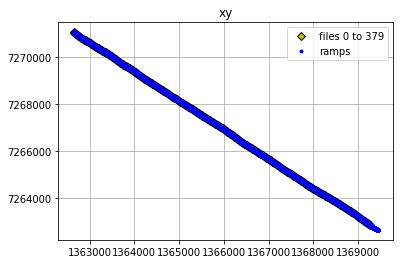

In [113]:
plt.figure()
plt.plot( x_selection, y_selection, 
         'Dy', markerEdgecolor='k', label = "files {} to {}".format( firstRecord, nbRecords[selectedRecord] ) )
plt.plot( gps_x, gps_y, '.b', label = 'ramps' )
plt.legend()
plt.title("xy")
plt.grid()

In [114]:
xyz_proj_allRamps.shape

(291750, 5)

### lla latitude longitude altitude

In [ ]:
allRamps_lat = np.interp( timestampsAllRamps, gpsNewTimestamps, Lat )
allRamps_long = np.interp( timestampsAllRamps, gpsNewTimestamps, Long )
allRamps_alt = np.interp( timestampsAllRamps, gpsNewTimestamps, Alt )
latLongAlt_allRamps = np.stack( (rampNumber, timestampsAllRamps,
                                 allRamps_lat, allRamps_long, allRamps_alt), -1 )

In [ ]:
np.save( data_dir[selectedRecord] + "/rampNumber_timeStamp_latLongAlt_gps", latLongAlt_allRamps )

## logEkfNav rampDown

In [ ]:
nav_x = np.interp( timestampsAllRamps, navNewTimestamps, nav_proj[0] )
nav_y = np.interp( timestampsAllRamps, navNewTimestamps, nav_proj[1] )
nav_z = np.interp( timestampsAllRamps, navNewTimestamps, nav_Alt )
nav_u = np.interp( timestampsAllRamps, navNewTimestamps, nav_Undulation )
nav_xyz_allRamps = np.stack( (rampNumber, timestampsAllRamps, 
                              nav_x, nav_y, nav_z), -1 )

In [ ]:
np.save( data_dir[selectedRecord] + "/rampNumber_timeStamp_xyz_nav", nav_xyz_allRamps )

In [ ]:
nav_allRamps_lat = np.interp( timestampsAllRamps, navNewTimestamps, nav_Lat )
nav_allRamps_long = np.interp( timestampsAllRamps, navNewTimestamps, nav_Long )
nav_allRamps_alt = np.interp( timestampsAllRamps, navNewTimestamps, nav_Alt )
nav_latLongAlt_allRamps = np.stack( (rampNumber, timestampsAllRamps, 
                              nav_allRamps_lat, nav_allRamps_long, nav_allRamps_alt), -1 )

In [ ]:
np.save( data_dir[selectedRecord] + "/rampNumber_timeStamp_latLongAlt_nav", nav_latLongAlt_allRamps )

In [ ]:
plt.figure()
plt.plot(nav_u)

## Compare gps and nav

In [ ]:
plt.figure()
plt.plot( gps_x, gps_y, label="gps" )
plt.plot( nav_x, nav_y, label="nav" )
plt.legend()
plt.grid()
plt.title("x-y")

In [ ]:
plt.figure()
plt.plot( gps_z, label="gps"  )
plt.plot( nav_z, label="nav" )
plt.legend()
plt.grid()
plt.title("z")

## logGpsPos rampUp

In [ ]:
# rampNumber timeStamp x y z

timeStamp_ext_up = np.concatenate( 
    (selectedTimeStamp, [ selectedTimeStamp[-1] + selectedTimeStamp[-1] - selectedTimeStamp[-2] ] ) ) \
    + params.configuredTRamp / 2

timeStamp = np.interp( rampNumber, rampNumber_ext, timeStamp_ext_up)
x = np.interp( timeStamp, gpsNewTimestamps, gps_proj[0] )
y = np.interp( timeStamp, gpsNewTimestamps, gps_proj[1] )
z = np.interp( timeStamp, gpsNewTimestamps, Alt )
xyz_proj_allRamps = np.stack( (rampNumber, timeStamp, x, y, z), -1 )

In [ ]:
np.save( data_dir[selectedRecord] + "/rampNumber_timeStamp_xyz_rampUp", xyz_proj_allRamps )

In [ ]:
plt.figure()
plt.plot(rampNumber_ext, timeStamp_ext, 'o')
plt.plot(rampNumber_ext, timeStamp_ext_up, '.')